# Load Data

 points to consider:
 - for "unsupervised" learning, make sure we don't train on test_data (== labelled data)

## Train Data

In [24]:
import pandas as pd # DataFrame Manipulation Package
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
data = pd.read_csv('../raw_data/drugsComTrain_raw.csv')
data.head()

train_data = data[300:5300].drop(["uniqueID", "condition", "rating", "date", "usefulCount"], axis =1)
print(train_data.shape)
train_data.head()

(5000, 2)


,drugName,review
300,Nitrofurantoin,"""Although I think I might have kidney stones i..."
301,Metronidazole,"""I&#039;ve been taking metronidazoles for 4 da..."
302,Ziprasidone,"""This was the worst experience I&#039;ve had w..."
303,Acetaminophen / butalbital / caffeine,"""I have been suffering from terrible allergies..."
304,Naproxen,"""One thing I&#039;ve learned is to avoid dairy..."


In [26]:
# data cleaning
import string 

def remove_punct(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    text = text.replace('\n', ' ')
    return text

def to_lower(text):
    return text.lower()

def remove_numbers(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text) 
    text = [w for w in word_tokens if not w in stop_words]
    text = ' '.join(text)
    return text

from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    text = ''.join(lemmatized)
    return text

In [27]:
train_data["clean_review"] = train_data["review"].apply(remove_punct).apply(to_lower).apply(remove_numbers).apply(remove_stopwords).apply(lemmatize_text)

train_data.head()

,drugName,review,clean_review
300,Nitrofurantoin,"""Although I think I might have kidney stones i...",although think might kidney stones instead uti...
301,Metronidazole,"""I&#039;ve been taking metronidazoles for 4 da...",ive taking metronidazoles days day im still ag...
302,Ziprasidone,"""This was the worst experience I&#039;ve had w...",worst experience ive medication go lithium gav...
303,Acetaminophen / butalbital / caffeine,"""I have been suffering from terrible allergies...",suffering terrible allergies due hay fever all...
304,Naproxen,"""One thing I&#039;ve learned is to avoid dairy...",one thing ive learned avoid dairy products muc...


## Test Data

In [28]:
test_data = pd.read_csv('../raw_data/adr_labelled_data.csv', nrows = 300)
test_data = test_data.drop(["uniqueID", "condition", "date", "usefulCount", "Unnamed: 8"], axis =1)
test_data.tail()

,drugName,review,rating,sideEffect
295,Ethinyl estradiol / norgestimate,"""First of all, I started taking birth control ...",1,1
296,AndroGel,"""I am 69 years old. Prior to starting 5 pump...",5,1
297,Ethinyl estradiol / norgestimate,"""Face cleared. Gained 5 pounds. No vomiting fo...",7,1
298,Victoza,"""All the side effects""",1,1
299,Ethinyl estradiol / norgestimate,"""Slow and steady definitely wins this race. I ...",9,1


In [29]:
test_data["clean_review"] = test_data["review"].apply(remove_punct).apply(to_lower).apply(remove_numbers).apply(remove_stopwords).apply(lemmatize_text)

test_data.head()

,drugName,review,rating,sideEffect,clean_review
0,Valsartan,"""It has no side effect, I take it in combinati...",9,0,side effect take combination bystolic mg fish oil
1,Guanfacine,"""My son is halfway through his fourth week of ...",8,1,son halfway fourth week intuniv became concern...
2,Lybrel,"""I used to take another oral contraceptive, wh...",5,1,used take another oral contraceptive pill cycl...
3,Ortho Evra,"""This is my first time using any form of birth...",8,1,first time using form birth control im glad we...
4,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,1,suboxone completely turned life around feel he...


<AxesSubplot:xlabel='rating', ylabel='count'>

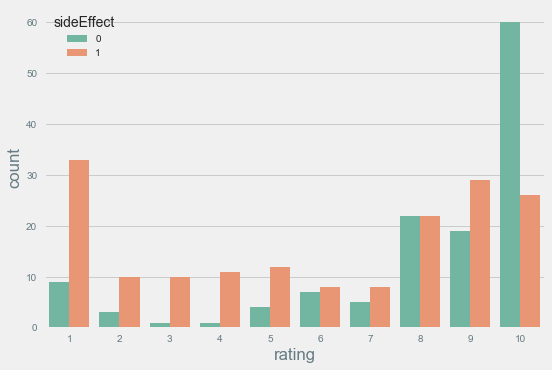

In [126]:
sns.countplot(x="rating", hue="sideEffect", data=test_data, palette="Set2")

In [99]:
df_plot = test_data[['drugName', 'rating', 'sideEffect']].groupby(['rating', 'sideEffect'])
df_plot = df_plot.size().reset_index().pivot(columns='sideEffect', index='rating', values=0)

print(df_plot)

sideEffect   0   1
rating            
1            9  33
2            3  10
3            1  10
4            1  11
5            4  12
6            7   8
7            5   8
8           22  22
9           19  29
10          60  26


In [103]:
totals = [i+j for i,j in zip(df_plot[0], df_plot[1])]
totals
df_plot[0] = [i / j * 100 for i,j in zip(df_plot[0], totals)]
df_plot[1] = [i / j * 100 for i,j in zip(df_plot[1], totals)]

df_plot  = df_plot[[1, 0]]
df_plot

sideEffect,1,0
rating,,
1,78.571429,21.428571
2,76.923077,23.076923
3,90.909091,9.090909
4,91.666667,8.333333
5,75.000000,25.000000
6,53.333333,46.666667
7,61.538462,38.461538
8,50.000000,50.000000
9,60.416667,39.583333


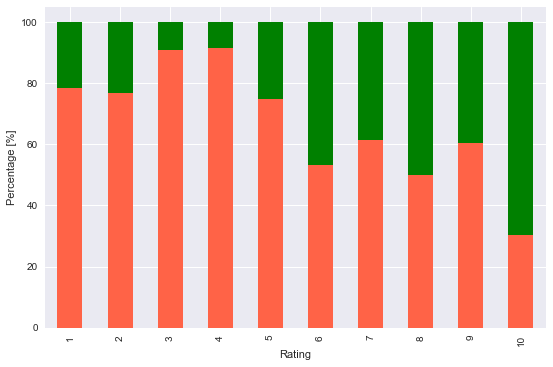

In [139]:
df_plot.plot(kind='bar', stacked=True, color=['tomato', 'g'], legend=None)
plt.ylabel("Percentage [%]")
plt.xlabel("Rating")
plt.style.use('seaborn')
plt.savefig('rating.png')

# Feature Engineering

## Prepare dataset without "side effects"

In [31]:
train_data['clean_review_without_se'] = train_data['clean_review'].str.replace('side', '')
train_data['clean_review_without_se'] = train_data['clean_review_without_se'].str.replace('effects', '')
train_data.head()

,drugName,review,clean_review,clean_review_without_se
300,Nitrofurantoin,"""Although I think I might have kidney stones i...",although think might kidney stones instead uti...,although think might kidney stones instead uti...
301,Metronidazole,"""I&#039;ve been taking metronidazoles for 4 da...",ive taking metronidazoles days day im still ag...,ive taking metronidazoles days day im still ag...
302,Ziprasidone,"""This was the worst experience I&#039;ve had w...",worst experience ive medication go lithium gav...,worst experience ive medication go lithium gav...
303,Acetaminophen / butalbital / caffeine,"""I have been suffering from terrible allergies...",suffering terrible allergies due hay fever all...,suffering terrible allergies due hay fever all...
304,Naproxen,"""One thing I&#039;ve learned is to avoid dairy...",one thing ive learned avoid dairy products muc...,one thing ive learned avoid dairy products muc...


In [32]:
test_data['clean_review_without_se'] = test_data['clean_review'].str.replace('side', '')
test_data['clean_review_without_se'] = test_data['clean_review_without_se'].str.replace('effects', '')
test_data.head()

,drugName,review,rating,sideEffect,clean_review,clean_review_without_se
0,Valsartan,"""It has no side effect, I take it in combinati...",9,0,side effect take combination bystolic mg fish oil,effect take combination bystolic mg fish oil
1,Guanfacine,"""My son is halfway through his fourth week of ...",8,1,son halfway fourth week intuniv became concern...,son halfway fourth week intuniv became concern...
2,Lybrel,"""I used to take another oral contraceptive, wh...",5,1,used take another oral contraceptive pill cycl...,used take another oral contraceptive pill cycl...
3,Ortho Evra,"""This is my first time using any form of birth...",8,1,first time using form birth control im glad we...,first time using form birth control im glad we...
4,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,1,suboxone completely turned life around feel he...,suboxone completely turned life around feel he...


## Create word-count feature

In [33]:
wordcount = [len(train_data.review.iloc[index].split()) for index in range(len(train_data))]
train_data["wordcount"] = wordcount

train_data.head()

,drugName,review,clean_review,clean_review_without_se,wordcount
300,Nitrofurantoin,"""Although I think I might have kidney stones i...",although think might kidney stones instead uti...,although think might kidney stones instead uti...,91
301,Metronidazole,"""I&#039;ve been taking metronidazoles for 4 da...",ive taking metronidazoles days day im still ag...,ive taking metronidazoles days day im still ag...,53
302,Ziprasidone,"""This was the worst experience I&#039;ve had w...",worst experience ive medication go lithium gav...,worst experience ive medication go lithium gav...,135
303,Acetaminophen / butalbital / caffeine,"""I have been suffering from terrible allergies...",suffering terrible allergies due hay fever all...,suffering terrible allergies due hay fever all...,55
304,Naproxen,"""One thing I&#039;ve learned is to avoid dairy...",one thing ive learned avoid dairy products muc...,one thing ive learned avoid dairy products muc...,48


In [34]:
wordcount = [len(test_data.review.iloc[index].split()) for index in range(len(test_data))]
test_data["wordcount"] = wordcount

test_data.head()

,drugName,review,rating,sideEffect,clean_review,clean_review_without_se,wordcount
0,Valsartan,"""It has no side effect, I take it in combinati...",9,0,side effect take combination bystolic mg fish oil,effect take combination bystolic mg fish oil,17
1,Guanfacine,"""My son is halfway through his fourth week of ...",8,1,son halfway fourth week intuniv became concern...,son halfway fourth week intuniv became concern...,141
2,Lybrel,"""I used to take another oral contraceptive, wh...",5,1,used take another oral contraceptive pill cycl...,used take another oral contraceptive pill cycl...,134
3,Ortho Evra,"""This is my first time using any form of birth...",8,1,first time using form birth control im glad we...,first time using form birth control im glad we...,89
4,Buprenorphine / naloxone,"""Suboxone has completely turned my life around...",9,1,suboxone completely turned life around feel he...,suboxone completely turned life around feel he...,124


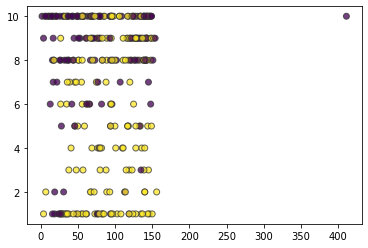

In [35]:
plt.scatter(test_data['wordcount'], test_data['rating'], edgecolor='#333333', alpha=0.75, c=test_data['sideEffect'])

## Count Mentioning of drug name

In [36]:
splittes = [(train_data.clean_review.iloc[index].split()) for index in range(len(train_data))]
train_data["splitted"] = splittes

'kidney' in train_data.splitted.iloc[0]

True

In [37]:
[(train_data.clean_review.iloc[index].split()) for index in range(len(train_data))]

[['although',
  'think',
  'might',
  'kidney',
  'stones',
  'instead',
  'uti',
  'due',
  'vast',
  'amounts',
  'blood',
  'urine',
  'pain',
  'urinate',
  'side',
  'effect',
  'nausea',
  'cant',
  'say',
  'actually',
  'helped',
  'symptoms',
  'still',
  'side',
  'belly',
  'pain',
  'days',
  'one',
  'person',
  'might',
  'one',
  'side',
  'effect',
  'allergic',
  'reaction',
  'doesnt',
  'mean',
  'next',
  'person',
  'everyones',
  'body',
  'different',
  'doesnt',
  'work',
  'one',
  'person',
  'might',
  'work'],
 ['ive',
  'taking',
  'metronidazoles',
  'days',
  'day',
  'im',
  'still',
  'agony',
  'ive',
  'tried',
  'many',
  'painkillers',
  'nothing',
  'helps',
  'right',
  'side',
  'face',
  'agony',
  'cant',
  'eat',
  'drink',
  'anything',
  'hot',
  'cold',
  'cold',
  'air',
  'hurts',
  'gums',
  'also',
  'anyone',
  'advice'],
 ['worst',
  'experience',
  'ive',
  'medication',
  'go',
  'lithium',
  'gave',
  'hypothyroidism',
  'diabetes'

In [38]:
train_data.drugName.iloc[3].lower()

'acetaminophen / butalbital / caffeine'

In [39]:
train_data.clean_review.iloc[3]

'suffering terrible allergies due hay fever allergies caused horrible headaches doctor gave prescription butalbital fioricet helped much taking excedrin migraine however keeping night everyone suffers must try inexpensive compared migraine medications'

In [40]:
train_data.drugName.iloc[1] in train_data.clean_review.iloc[1]

False

# Unsupervised

## Simple LDA

In [41]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (2,2)).fit(train_data['clean_review'])
data_vectorized = vectorizer.transform(train_data['clean_review'])

lda_model = LatentDirichletAllocation(n_components=2).fit(data_vectorized)

In [42]:
# visualise output
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-10 - 1:-1]])
        
print_topics(lda_model, vectorizer)

Topic 0:
[('side effects', 36.97320093978534), ('birth control', 20.416178822654913), ('works great', 12.93648911259256), ('weight gain', 11.673407719709374), ('mood swings', 10.968032648973146), ('side effect', 10.288157870728382), ('started taking', 10.144604809910573), ('sex drive', 8.52049406007985), ('first time', 8.453164255510748), ('feel like', 7.781698642689893)]
Topic 1:
[('side effects', 28.061905190983627), ('birth control', 12.870252967340829), ('weight gain', 9.33098738090195), ('side effect', 9.14892373667104), ('started taking', 8.699586887349735), ('feel like', 8.295520392220864), ('mood swings', 7.941299531606023), ('two weeks', 7.318739182177511), ('felt like', 6.89787239764592), ('take mg', 6.733289354944462)]


## Interpretation

In [43]:
# dummy test: is 'side effect' a topic?
example = ["side effect"]

example_vectorized = vectorizer.transform(example)
lda_vectors = lda_model.transform(example_vectorized)

print("topic 0 :", lda_vectors[0][0])
print("topic 1 :", lda_vectors[0][1]) 
# nope, makes sense, since it hasn't seen it before, it doesnt know where to put it.

topic 0 : 0.5698624307930652
topic 1 : 0.43013756920693486


In [44]:
# transform test_data
test_data_vectorized = vectorizer.transform(test_data['clean_review'])

lda_vectors = lda_model.transform(test_data_vectorized)

In [45]:
# Compare
predicted_topic = []
for row in range(len(test_data)):
    if (lda_vectors[row][0] > lda_vectors[row][1]):
        predicted_topic.append(0)
    else: predicted_topic.append(1)

((np.array(predicted_topic) == np.array(test_data.sideEffect)).sum()) / 3

## 55% --> pretty much randomly assigned

47.666666666666664

# Supervised Learing 

## Create X_train, X_test, y_train, y_test

In [46]:
from sklearn.model_selection import train_test_split

tfidf_vectorizer = TfidfVectorizer(max_df = 0.8)

X = test_data.drop("sideEffect", axis=1)
y = test_data.sideEffect

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 4)

X_train_vec = tfidf_vectorizer.fit_transform(X_train["clean_review"])
X_test_vec = tfidf_vectorizer.transform(X_test["clean_review"])

In [47]:
X_train_vec, X_test_vec, y_train, y_test

(<210x2451 sparse matrix of type '<class 'numpy.float64'>'
 	with 7703 stored elements in Compressed Sparse Row format>,
 <90x2451 sparse matrix of type '<class 'numpy.float64'>'
 	with 2721 stored elements in Compressed Sparse Row format>,
 291    1
 226    1
 154    1
 48     1
 101    1
       ..
 58     0
 87     0
 197    0
 174    0
 122    1
 Name: sideEffect, Length: 210, dtype: int64,
 293    1
 166    1
 18     1
 43     0
 241    0
       ..
 134    0
 111    0
 212    1
 278    0
 264    1
 Name: sideEffect, Length: 90, dtype: int64)

## MNBayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train_vec,y_train)
nb_model.score(X_test_vec,y_test)

0.6555555555555556

In [49]:
# as crossvalidation
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(data[test_data.clean_review])
.toarray()

y = test_data.sideEffect
nb_model = MultinomialNB()

cv_results = cross_validate(nb_model, X_bow, y, cv=5)

cv_results['test_score'].mean()

SyntaxError: invalid syntax (<ipython-input-49-4d80ad74d2ce>, line 7)

## Logistic Regression

In [50]:
# Instanciate the model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000)

# Train the model on the Training data
log_model.fit(X_train_vec, y_train)
# Score the model on the Testing data
print(log_model.score(X_test_vec,y_test))

0.7222222222222222


In [136]:
X_train[['rating', 'wordcount', 'drugName']].head()

,rating,wordcount,drugName
291,4,140,Levonorgestrel
226,1,137,Ethinyl estradiol / norethindrone
154,5,117,Ethinyl estradiol / norgestimate
48,4,101,Tamsulosin
101,8,126,Lurasidone


In [135]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(X_train[['drugName']])

X.toarray()
pd.DataFrame(X.toarray(),columns = vectorizer.get_feature_names())

,drugname
0,1


In [56]:
# Instanciate the model
from sklearn.linear_model import LogisticRegression
log_model2 = LogisticRegression(max_iter=1000)

# Train the model on the Training data
log_model2.fit(X_train[['rating', 'wordcount']], y_train)
# Score the model on the Testing data
print(log_model2.score(X_test[['rating', 'wordcount']],y_test))

0.7
